In [102]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
from matplotlib.patches import Polygon
import shap

from Functions import prep_training_test_data, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data, add_labels_to_subplots, LOOCV_by_HSA_dataset, save_in_HSA_dictionary, prepare_data_and_model, calculate_maximum_reget
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']


In [77]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_incl_NA.csv")
columns_to_remove = [col for col in HSA_weekly_data_all.columns if 'cases' in col]
HSA_weekly_data_no_cases_no_deaths = HSA_weekly_data_all.drop(columns=columns_to_remove)

columns_to_remove = [col for col in HSA_weekly_data_no_cases_no_deaths.columns if 'deaths' in col]
HSA_weekly_data_no_cases_no_deaths = HSA_weekly_data_no_cases_no_deaths.drop(columns=columns_to_remove)


# Polygons for mapping onto waves

In [79]:

## County Data 


data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')

data_by_county = data_by_county.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])
data_by_county['CTYNAME'] = data_by_county['CTYNAME'].apply(lambda x: x.split()[0])
data_by_county['CTYNAME'] = data_by_county['fips'].astype(str) + '' + data_by_county['CTYNAME']
data_by_county['beds_over_15_100k'] = (data_by_county['beds_weekly'] > 15) * 1

# Redo dates
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i

## DELTA POLYGON 

start_date = pd.to_datetime('2021-06-30')
end_date = pd.to_datetime('2021-10-26')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_delta = data_by_county.loc[matching_indices_start, 'week']
last_week_delta = data_by_county.loc[matching_indices_end, 'week']
start_date = pd.to_datetime('2021-10-26')
end_date = pd.to_datetime('2022-09-27')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_omricon = data_by_county.loc[matching_indices_start, 'week']
last_week_omricon = data_by_county.loc[matching_indices_end, 'week']

## CDC POLYGON 
start_date = pd.to_datetime('2021-03-01')
end_date = pd.to_datetime('2022-01-24')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_CDC = data_by_county.loc[matching_indices_start, 'week']
last_week_CDC = data_by_county.loc[matching_indices_end, 'week']

Columns (47,48,49,50,51,55,56) have mixed types. Specify dtype option on import or set low_memory=False.


# Percent exceeding capacity 

In [80]:
percent_exceed_capacity = []

# Iterate through the columns of the DataFrame
for column_name in HSA_weekly_data_all.columns:
    if 'beds_over_15_100k' in column_name:
        # Calculate the sum of the column and append it to the list
        column_sum = HSA_weekly_data_all[column_name].sum()/len(HSA_weekly_data_all[column_name])
        percent_exceed_capacity.append(column_sum)

# Dictionaries to save data

In [81]:
model_metric_ROC = {}
model_metric_accuracy = {}
model_metric_MCC = {}

model_metric_ROC = {}
model_metric_accuracy_CDC_A = {}
model_metric_MCC_CDC_A = {}

model_metric_ROC_CDC_B = {}
model_metric_accuracy_CDC_B = {}
model_metric_MCC_CDC_B = {}

# Parameters for hyperparameter tuning 

In [82]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'exact'  # Choose 'period', 'exact', or 'exact'
size_of_test_dataset = 1

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  
no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations


# 4 weeks of data

In [83]:
weeks_to_predict_four_week = range(1, 121 - 1 - 3  - 1 - 4)

model_metric_ROC['ROC_by_week_full_period_4_week'] = []
model_metric_accuracy['accuracy_by_week_full_period_4_week'] = []
model_metric_MCC['norm_MCC_by_week_full_period_4_week'] = []

keep_output = True

size_of_test_dataset = 1
for prediction_week in weeks_to_predict_four_week:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/4_week_models/Full_model_smaller_hyperparameters" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 4) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 4) + 1, int(prediction_week + 4 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full_period = weights_full_period[0].to_numpy()


    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model

    model_metric_ROC['ROC_by_week_full_period_4_week'].append(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_full_period_4_week'].append(accuracy_score(y_test_full_period, y_pred))
    model_metric_MCC['norm_MCC_by_week_full_period_4_week'].append((matthews_corrcoef(y_test_full_period, y_pred) + 1)/2)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111


In [84]:
weeks_to_predict_four_week = range(1, 121 - 1 - 3  - 1 - 4)

model_metric_ROC['ROC_by_week_no_c_d_period_4_week'] = []
model_metric_accuracy['accuracy_by_week_no_c_d_period_4_week'] = []
model_metric_MCC['norm_MCC_by_week_no_c_d_period_4_week'] = []

keep_output = True

size_of_test_dataset = 1
for prediction_week in weeks_to_predict_four_week:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/No_cases_no_deaths/4_week_models/No_cases_no_deaths_smaller_hyperparameters_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_no_cases_no_deaths, no_weeks=range(prediction_week, int(prediction_week + 4) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_no_cases_no_deaths, no_weeks=range(int(prediction_week + 4) + 1, int(prediction_week + 4 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full_period = weights_full_period[0].to_numpy()


    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model

    model_metric_ROC['ROC_by_week_no_c_d_period_4_week'].append(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_no_c_d_period_4_week'].append(accuracy_score(y_test_full_period, y_pred))
    model_metric_MCC['norm_MCC_by_week_no_c_d_period_4_week'].append((matthews_corrcoef(y_test_full_period, y_pred) + 1)/2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111


In [85]:
weeks_to_predict_four_week = range(1, 121 - 1 - 3  - 1 - 4)

model_metric_ROC['ROC_by_week_CDC_A_period_4_week'] = []
model_metric_accuracy['accuracy_by_week_CDC_A_period_4_week'] = []
model_metric_MCC['norm_MCC_by_week_CDC_A_period_4_week'] = []
keep_output = False
size_of_test_dataset = 1
for prediction_week in weeks_to_predict_four_week:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/4_week_models/CDC_A_smaller_hyperparameters" + time_period + "_" + str(prediction_week) + ".sav"
    clf_CDC_A_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_CDC_A_period, y_train_CDC_A_period, weights_CDC_A_period, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 4) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)

    X_test_CDC_A_period, y_test_CDC_A_period, weights_test_CDC_A_period, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 4) + 1, int(prediction_week + 4 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
    weights_CDC_A_period = weights_CDC_A_period[0].to_numpy()

    clf_CDC_A_period.fit(X_train_CDC_A_period, y_train_CDC_A_period, sample_weight=weights_CDC_A_period)

    # Make predictions on the test set
    y_pred = clf_CDC_A_period.predict(X_test_CDC_A_period)
    y_pred_proba = clf_CDC_A_period.predict_proba(X_test_CDC_A_period)

    # Evaluate the accuracy of the model
    model_metric_ROC['ROC_by_week_CDC_A_period_4_week'].append(roc_auc_score(y_test_CDC_A_period, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_CDC_A_period_4_week'].append(accuracy_score(y_test_CDC_A_period, y_pred))
    model_metric_MCC['norm_MCC_by_week_CDC_A_period_4_week'].append((matthews_corrcoef(y_test_CDC_A_period, y_pred) + 1)/2)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111


In [86]:
weeks_to_predict_four_week = range(1, 121 - 1 - 3  - 1 - 4)

model_metric_ROC['ROC_by_week_CDC_B_period_4_week'] = []
model_metric_accuracy['accuracy_by_week_CDC_B_period_4_week'] = []
model_metric_MCC['norm_MCC_by_week_CDC_B_period_4_week'] = []
keep_output = True

size_of_test_dataset = 1
for prediction_week in weeks_to_predict_four_week:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/4_week_models/CDC_B_smaller_hyperparameters" + time_period + "_" + str(prediction_week) + ".sav"
    clf_CDC_B_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_CDC_B_period, y_train_CDC_B_period, weights_CDC_B_period, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 4) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)

    X_test_CDC_B_period, y_test_CDC_B_period, weights_test_CDC_B_period, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 4) + 1, int(prediction_week + 4 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
    weights_CDC_B_period = weights_CDC_B_period[0].to_numpy()

    clf_CDC_B_period.fit(X_train_CDC_B_period, y_train_CDC_B_period, sample_weight=weights_CDC_B_period)

    # Make predictions on the test set
    y_pred = clf_CDC_B_period.predict(X_test_CDC_B_period)
    y_pred_proba = clf_CDC_B_period.predict_proba(X_test_CDC_B_period)

    # Evaluate the accuracy of the model
    model_metric_ROC['ROC_by_week_CDC_B_period_4_week'].append(roc_auc_score(y_test_CDC_B_period, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_CDC_B_period_4_week'].append(accuracy_score(y_test_CDC_B_period, y_pred))
    model_metric_MCC['norm_MCC_by_week_CDC_B_period_4_week'].append((matthews_corrcoef(y_test_CDC_B_period, y_pred) + 1)/2)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111


# 10 weeks of data

In [90]:
weeks_to_predict_ten_week = range(1, 121 - 1 - 3 - 10 - 1)
model_metric_ROC['ROC_by_week_full_period_10_week'] = []
model_metric_accuracy['accuracy_by_week_full_period_10_week'] = []
model_metric_MCC['norm_MCC_by_week_full_period_10_week'] = []

#for i in range(0,11): # add one week to account for the initial training week 
#    model_metric_ROC['ROC_by_week_full_period_10_week'].append(0)
#    model_metric_accuracy['accuracy_by_week_full_period_10_week'].append(0)
#    model_metric_MCC['norm_MCC_by_week_full_period_10_week'].append(0)
keep_output = True
size_of_test_dataset = 1
for prediction_week in weeks_to_predict_ten_week:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/10_week_models/Full_model_smaller_hyperparameters" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 10) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 10) + 1, int(prediction_week + 10 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
    weights_full_period = weights_full_period[0].to_numpy()


    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model



    model_metric_ROC['ROC_by_week_full_period_10_week'].append(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_full_period_10_week'].append(accuracy_score(y_test_full_period, y_pred))
    model_metric_MCC['norm_MCC_by_week_full_period_10_week'].append((matthews_corrcoef(y_test_full_period, y_pred) + 1)/2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105


In [96]:
weeks_to_predict_ten_week = range(1, 121 - 1 - 3 - 10 - 1)
model_metric_ROC['ROC_by_week_no_c_d_period_10_week'] = []
model_metric_accuracy['accuracy_by_week_no_c_d_period_10_week'] = []
model_metric_MCC['norm_MCC_by_week_no_c_d_period_10_week'] = []

#for i in range(0,11): # add one week to account for the initial training week 
#    model_metric_ROC['ROC_by_week_full_period_10_week'].append(0)
#    model_metric_accuracy['accuracy_by_week_full_period_10_week'].append(0)
#    model_metric_MCC['norm_MCC_by_week_full_period_10_week'].append(0)
keep_output = True
size_of_test_dataset = 1
for prediction_week in weeks_to_predict_ten_week:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/No_cases_no_deaths/10_week_models/No_cases_no_deaths_smaller_hyperparameters_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_no_cases_no_deaths, no_weeks=range(prediction_week, int(prediction_week + 10) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_no_cases_no_deaths, no_weeks=range(int(prediction_week + 10) + 1, int(prediction_week + 10 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
    weights_full_period = weights_full_period[0].to_numpy()


    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    model_metric_ROC['ROC_by_week_no_c_d_period_10_week'].append(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_no_c_d_period_10_week'].append(accuracy_score(y_test_full_period, y_pred))
    model_metric_MCC['norm_MCC_by_week_no_c_d_period_10_week'].append((matthews_corrcoef(y_test_full_period, y_pred) + 1)/2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105


In [92]:
weeks_to_predict_ten_week = range(1, 121 - 1 - 3 - 10 - 1)
model_metric_ROC['ROC_by_week_CDC_A_period_10_week'] = []
model_metric_accuracy['accuracy_by_week_CDC_A_period_10_week'] = []
model_metric_MCC['norm_MCC_by_week_CDC_A_period_10_week'] = []

#for i in range(0,11): # add one week to account for the initial training week 
#    model_metric_ROC['ROC_by_week_CDC_A_period_10_week'].append(0)
#    model_metric_accuracy['accuracy_by_week_CDC_A_period_10_week'].append(0)
#    model_metric_MCC['norm_MCC_by_week_CDC_A_period_10_week'].append(0)
keep_output = False
size_of_test_dataset = 1
for prediction_week in weeks_to_predict_ten_week:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/10_week_models/CDC_A_smaller_hyperparameters" + time_period + "_" + str(prediction_week) + ".sav"
    clf_CDC_A_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_CDC_A_period, y_train_CDC_A_period, weights_CDC_A_period, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 10) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)

    X_test_CDC_A_period, y_test_CDC_A_period, weights_test_CDC_A_period, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 10) + 1, int(prediction_week + 10 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
    weights_CDC_A_period = weights_CDC_A_period[0].to_numpy()

    clf_CDC_A_period.fit(X_train_CDC_A_period, y_train_CDC_A_period, sample_weight=weights_CDC_A_period)

    # Make predictions on the test set
    y_pred = clf_CDC_A_period.predict(X_test_CDC_A_period)
    y_pred_proba = clf_CDC_A_period.predict_proba(X_test_CDC_A_period)

    # Evaluate the accuracy of the model
    model_metric_ROC['ROC_by_week_CDC_A_period_10_week'].append(roc_auc_score(y_test_CDC_A_period, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_CDC_A_period_10_week'].append(accuracy_score(y_test_CDC_A_period, y_pred))
    model_metric_MCC['norm_MCC_by_week_CDC_A_period_10_week'].append((matthews_corrcoef(y_test_CDC_A_period, y_pred) + 1)/2)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105


In [93]:
weeks_to_predict_ten_week = range(1, 121 - 1 - 3 - 10 - 1)
model_metric_ROC['ROC_by_week_CDC_B_period_10_week'] = []
model_metric_accuracy['accuracy_by_week_CDC_B_period_10_week'] = []
model_metric_MCC['norm_MCC_by_week_CDC_B_period_10_week'] = []

#for i in range(0,11): # add one week to account for the initial training week 
#    model_metric_ROC['ROC_by_week_CDC_B_period_10_week'].append(0)
#    model_metric_accuracy['accuracy_by_week_CDC_B_period_10_week'].append(0)
#    model_metric_MCC['norm_MCC_by_week_CDC_B_period_10_week'].append(0)
keep_output = True
size_of_test_dataset = 1
for prediction_week in weeks_to_predict_ten_week:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/10_week_models/CDC_B_smaller_hyperparameters" + time_period + "_" + str(prediction_week) + ".sav"
    clf_CDC_B_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_CDC_B_period, y_train_CDC_B_period, weights_CDC_B_period, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 10) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)

    X_test_CDC_B_period, y_test_CDC_B_period, weights_test_CDC_B_period, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 10) + 1, int(prediction_week + 10 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
    weights_CDC_B_period = weights_CDC_B_period[0].to_numpy()

    clf_CDC_B_period.fit(X_train_CDC_B_period, y_train_CDC_B_period, sample_weight=weights_CDC_B_period)

    # Make predictions on the test set
    y_pred = clf_CDC_B_period.predict(X_test_CDC_B_period)
    y_pred_proba = clf_CDC_B_period.predict_proba(X_test_CDC_B_period)

    # Evaluate the accuracy of the model
    model_metric_ROC['ROC_by_week_CDC_B_period_10_week'].append(roc_auc_score(y_test_CDC_B_period, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_CDC_B_period_10_week'].append(accuracy_score(y_test_CDC_B_period, y_pred))
    model_metric_MCC['norm_MCC_by_week_CDC_B_period_10_week'].append((matthews_corrcoef(y_test_CDC_B_period, y_pred) + 1)/2)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105


# 26 weeks of data 

In [94]:
weeks_to_predict_twenty_six_week = range(1, 121 - 1 - 3 - 26 - 1) # 1 for the outcome week, 1 for the outcome period, 26 for the initial model, 1 for exact

model_metric_ROC['ROC_by_week_full_period_26_week'] = []
model_metric_accuracy['accuracy_by_week_full_period_26_week'] = []
model_metric_MCC['norm_MCC_by_week_full_period_26_week'] = []

#for i in range(0,27):  # add one week to account for the initial training week 
#    model_metric_ROC['ROC_by_week_full_period_26_week'].append(0)
#    model_metric_accuracy['accuracy_by_week_full_period_26_week'].append(0)
#    model_metric_MCC['norm_MCC_by_week_full_period_26_week'].append(0)

keep_output = True
size_of_test_dataset = 1
for prediction_week in weeks_to_predict_twenty_six_week:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/26_week_models/Full_model_smaller_hyperparameters" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
    weights_full_period = weights_full_period[0].to_numpy()


    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model

    model_metric_ROC['ROC_by_week_full_period_26_week'].append(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_full_period_26_week'].append(accuracy_score(y_test_full_period, y_pred))
    model_metric_MCC['norm_MCC_by_week_full_period_26_week'].append((matthews_corrcoef(y_test_full_period, y_pred) + 1)/2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


In [97]:
weeks_to_predict_twenty_six_week = range(1, 121 - 1 - 3 - 26 - 1) # 1 for the outcome week, 1 for the outcome period, 26 for the initial model, 1 for exact

model_metric_ROC['ROC_by_week_no_c_d_period_26_week'] = []
model_metric_accuracy['accuracy_by_week_no_c_d_period_26_week'] = []
model_metric_MCC['norm_MCC_by_week_no_c_d_period_26_week'] = []

#for i in range(0,27):  # add one week to account for the initial training week 
#    model_metric_ROC['ROC_by_week_full_period_26_week'].append(0)
#    model_metric_accuracy['accuracy_by_week_full_period_26_week'].append(0)
#    model_metric_MCC['norm_MCC_by_week_full_period_26_week'].append(0)

keep_output = True
size_of_test_dataset = 1
for prediction_week in weeks_to_predict_twenty_six_week:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/No_cases_no_deaths/26_week_models/No_cases_no_deaths_smaller_hyperparameters_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_no_cases_no_deaths, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_no_cases_no_deaths, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
    weights_full_period = weights_full_period[0].to_numpy()


    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model

    model_metric_ROC['ROC_by_week_no_c_d_period_26_week'].append(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_no_c_d_period_26_week'].append(accuracy_score(y_test_full_period, y_pred))
    model_metric_MCC['norm_MCC_by_week_no_c_d_period_26_week'].append((matthews_corrcoef(y_test_full_period, y_pred) + 1)/2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


In [98]:
weeks_to_predict_twenty_six_week = range(1, 121 - 1 - 3 - 26 - 1) # 1 for the outcome week, 1 for the outcome period, 26 for the initial model, 1 for exact

model_metric_ROC['ROC_by_week_CDC_A_period_26_week'] = []
model_metric_accuracy['accuracy_by_week_CDC_A_period_26_week'] = []
model_metric_MCC['norm_MCC_by_week_CDC_A_period_26_week'] = []

#for i in range(0,27):  # add one week to account for the initial training week 
#    model_metric_ROC['ROC_by_week_CDC_A_period_26_week'].append(0)
#    model_metric_accuracy['accuracy_by_week_CDC_A_period_26_week'].append(0)
#    model_metric_MCC['norm_MCC_by_week_CDC_A_period_26_week'].append(0)

keep_output = False
size_of_test_dataset = 1
for prediction_week in weeks_to_predict_twenty_six_week:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/26_week_models/CDC_A_smaller_hyperparameters" + time_period + "_" + str(prediction_week) + ".sav"
    clf_CDC_A_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_CDC_A_period, y_train_CDC_A_period, weights_CDC_A_period, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)

    X_test_CDC_A_period, y_test_CDC_A_period, weights_test_CDC_A_period, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
    weights_CDC_A_period = weights_CDC_A_period[0].to_numpy()

    clf_CDC_A_period.fit(X_train_CDC_A_period, y_train_CDC_A_period, sample_weight=weights_CDC_A_period)

    # Make predictions on the test set
    y_pred = clf_CDC_A_period.predict(X_test_CDC_A_period)
    y_pred_proba = clf_CDC_A_period.predict_proba(X_test_CDC_A_period)

    # Evaluate the accuracy of the model

    model_metric_ROC['ROC_by_week_CDC_A_period_26_week'].append(roc_auc_score(y_test_CDC_A_period, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_CDC_A_period_26_week'].append(accuracy_score(y_test_CDC_A_period, y_pred))
    model_metric_MCC['norm_MCC_by_week_CDC_A_period_26_week'].append((matthews_corrcoef(y_test_CDC_A_period, y_pred) + 1)/2)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


In [99]:
weeks_to_predict_twenty_six_week = range(1, 121 - 1 - 3 - 26 - 1) # 1 for the outcome week, 1 for the outcome period, 26 for the initial model, 1 for exact

model_metric_ROC['ROC_by_week_CDC_B_period_26_week'] = []
model_metric_accuracy['accuracy_by_week_CDC_B_period_26_week'] = []
model_metric_MCC['norm_MCC_by_week_CDC_B_period_26_week'] = []

#for i in range(0,27):  # add one week to account for the initial training week 
#    model_metric_ROC['ROC_by_week_CDC_B_period_26_week'].append(0)
#    model_metric_accuracy['accuracy_by_week_CDC_B_period_26_week'].append(0)
#    model_metric_MCC['norm_MCC_by_week_CDC_B_period_26_week'].append(0)

keep_output = True
size_of_test_dataset = 1
for prediction_week in weeks_to_predict_twenty_six_week:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/26_week_models/CDC_B_smaller_hyperparameters" + time_period + "_" + str(prediction_week) + ".sav"
    clf_CDC_B_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_CDC_B_period, y_train_CDC_B_period, weights_CDC_B_period, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)

    X_test_CDC_B_period, y_test_CDC_B_period, weights_test_CDC_B_period, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
    weights_CDC_B_period = weights_CDC_B_period[0].to_numpy()

    clf_CDC_B_period.fit(X_train_CDC_B_period, y_train_CDC_B_period, sample_weight=weights_CDC_B_period)

    # Make predictions on the test set
    y_pred = clf_CDC_B_period.predict(X_test_CDC_B_period)
    y_pred_proba = clf_CDC_B_period.predict_proba(X_test_CDC_B_period)

    # Evaluate the accuracy of the model

    model_metric_ROC['ROC_by_week_CDC_B_period_26_week'].append(roc_auc_score(y_test_CDC_B_period, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_CDC_B_period_26_week'].append(accuracy_score(y_test_CDC_B_period, y_pred))
    model_metric_MCC['norm_MCC_by_week_CDC_B_period_26_week'].append((matthews_corrcoef(y_test_CDC_B_period, y_pred) + 1)/2)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


# Naive model 

In [101]:
weeks_to_predict_expanding = range(1, 121)
model_metric_ROC['ROC_by_week_naive_period_4_week'] = []
model_metric_accuracy['accuracy_by_week_naive_period_4_week'] = []
model_metric_MCC['norm_MCC_by_week_naive_period_4_week'] = []

model_metric_ROC['ROC_by_week_naive_period_10_week'] = []
model_metric_accuracy['accuracy_by_week_naive_period_10_week'] = []
model_metric_MCC['norm_MCC_by_week_naive_period_10_week'] = []

model_metric_ROC['ROC_by_week_naive_period_26_week'] = []
model_metric_accuracy['accuracy_by_week_naive_period_26_week'] = []
model_metric_MCC['norm_MCC_by_week_naive_period_26_week'] = []
keep_output = True  

size_of_test_dataset = 1
for prediction_week in weeks_to_predict_expanding:
    print(prediction_week)
    if prediction_week < max(weeks_to_predict_four_week ) + 1:
        # 4 week     
        X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 4) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

        X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 4) + 1, int(prediction_week + 4 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
        weights_naive = weights_naive[0].to_numpy()
        # no hyperparameter tuning as is the same irrespective of hyperparameters
        clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
        clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

        # Make predictions on the test set
        y_pred = clf_naive.predict(X_test_naive)
        y_pred_proba = clf_naive.predict_proba(X_test_naive)

        # Evaluate the accuracy of the model
        model_metric_ROC['ROC_by_week_naive_period_4_week'].append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
        model_metric_accuracy['accuracy_by_week_naive_period_4_week'].append(accuracy_score(y_test_naive, y_pred))
        model_metric_MCC['norm_MCC_by_week_naive_period_4_week'].append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)

    # 10 week  
    if prediction_week < max(weeks_to_predict_ten_week) + 1:

        X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 10) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

        X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 10) + 1, int(prediction_week + 10 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
        weights_naive = weights_naive[0].to_numpy()
        # no hyperparameter tuning as it's the same irrespective of hyperparameters
        clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
        clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

        # Make predictions on the test set
        y_pred = clf_naive.predict(X_test_naive)
        y_pred_proba = clf_naive.predict_proba(X_test_naive)

        # Evaluate the accuracy of the model
        model_metric_ROC['ROC_by_week_naive_period_10_week'].append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
        model_metric_accuracy['accuracy_by_week_naive_period_10_week'].append(accuracy_score(y_test_naive, y_pred))
        model_metric_MCC['norm_MCC_by_week_naive_period_10_week'].append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)

    # 26 week 
    if prediction_week < max(weeks_to_predict_twenty_six_week) + 1:

        X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

        X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
        weights_naive = weights_naive[0].to_numpy()
        # no hyperparameter tuning as it's the same irrespective of hyperparameters
        clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
        clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

        # Make predictions on the test set
        y_pred = clf_naive.predict(X_test_naive)
        y_pred_proba = clf_naive.predict_proba(X_test_naive)

        # Evaluate the accuracy of the model
        model_metric_ROC['ROC_by_week_naive_period_26_week'].append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
        model_metric_accuracy['accuracy_by_week_naive_period_26_week'].append(accuracy_score(y_test_naive, y_pred))
        model_metric_MCC['norm_MCC_by_week_naive_period_26_week'].append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


# Maximum Regret

In [125]:
with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_full_exact.pkl', 'rb') as f:
    ROC_by_week_full_exact = pickle.load(f)
with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_naive_exact.pkl', 'rb') as f:
    ROC_by_week_naive_exact= pickle.load(f)

with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_CDC_A_exact.pkl', 'rb') as f:
    ROC_by_week_CDC_A_exact = pickle.load(f)
with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_CDC_B_exact.pkl', 'rb') as f:
    ROC_by_week_CDC_B_exact= pickle.load(f)

with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_no_c_d_exact.pkl', 'rb') as f:
    ROC_by_week_full_exact_removed = pickle.load(f)

with open('/Users/rem76/Documents/COVID_projections/percent_exceed_capacity.pkl', 'rb') as f:
    exceed_threshold= pickle.load(f)

with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_CL_mod.pkl', 'rb') as f:
    ROC_by_week_CL_mod = pickle.load(f)


In [112]:
def calculate_maximum_reget(
    metric, metrics_by_model, models, time_period, weeks_to_predict
):
    metric_data = metrics_by_model[metric]

    maximum_regret_by_model = {model: [] for model in models}
    for j, prediction_week in enumerate(weeks_to_predict):
        print(prediction_week)
        best_metric = float("-inf")

        for i, m in enumerate(metric_data):
            m = list(metric_data.values())[i]
            model_metric = m[prediction_week]
            if model_metric >= best_metric:
                best_metric = model_metric

        for i, m in enumerate(metric_data):
            m = list(metric_data.values())[i]
            model_metric = m[prediction_week]
            model = models[i]
            if model_metric >= best_metric:
                maximum_regret_by_model[model].append(0)
            else:
                maximum_regret_by_model[model].append(best_metric - model_metric)

    return maximum_regret_by_model

In [130]:
len_for_MR = len(model_metric_ROC['ROC_by_week_full_period_26_week'])
model_metric_ROC_4_MR = {
    'roc_values_naive_4': model_metric_ROC['ROC_by_week_naive_period_4_week'][-len_for_MR:],
    'roc_values_CDC_A_4': model_metric_ROC['ROC_by_week_CDC_A_period_4_week'][-len_for_MR:],
    #'roc_values_CDC_B_4': model_metric_ROC['ROC_by_week_CDC_B_period_4_week'][-len_for_MR:],
    'roc_values_no_c_d_4':model_metric_ROC['ROC_by_week_no_c_d_period_4_week'][-len_for_MR:],
    'roc_values_full_4': model_metric_ROC['ROC_by_week_full_period_4_week'][-len_for_MR:], 
    'ROC_by_week_CL_mod': ROC_by_week_CL_mod[-len_for_MR:]}

model_metric_ROC_10_MR = {
    'roc_values_naive_10': model_metric_ROC['ROC_by_week_naive_period_10_week'][-len_for_MR:],
    'roc_values_CDC_A_10': model_metric_ROC['ROC_by_week_CDC_A_period_10_week'][-len_for_MR:],
    #'roc_values_CDC_B_10': model_metric_ROC['ROC_by_week_CDC_B_period_10_week'][-len_for_MR:],
    'roc_values_no_c_d_10':model_metric_ROC['ROC_by_week_no_c_d_period_10_week'][-len_for_MR:],
    'roc_values_full_10': model_metric_ROC['ROC_by_week_full_period_10_week'][-len_for_MR:], 
    'ROC_by_week_CL_mod': ROC_by_week_CL_mod[-len_for_MR:]}

model_metric_ROC_26_MR = {
    'roc_values_naive_26': model_metric_ROC['ROC_by_week_naive_period_26_week'][-len_for_MR:],
    'roc_values_CDC_A_26': model_metric_ROC['ROC_by_week_CDC_A_period_26_week'][-len_for_MR:],
    #'roc_values_CDC_B_26': model_metric_ROC['ROC_by_week_CDC_B_period_26_week'][-len_for_MR:],
    'roc_values_no_c_d_26':model_metric_ROC['ROC_by_week_no_c_d_period_26_week'][-len_for_MR:],
    'roc_values_full_26': model_metric_ROC['ROC_by_week_full_period_26_week'][-len_for_MR:], 
    'ROC_by_week_CL_mod': ROC_by_week_CL_mod[-len_for_MR:]}

model_metric_ROC_expanding_MR = {
    'roc_values_naive_expand': ROC_by_week_naive_exact[-len_for_MR:],
    'roc_values_CDC_A_expand': ROC_by_week_CDC_A_exact[-len_for_MR:],
    #'roc_values_CDC_B_expand': ROC_by_week_CDC_B_exact[-len_for_MR:],
    'roc_values_no_c_d_expand': ROC_by_week_full_exact_removed[-len_for_MR:],
    'roc_values_full_expand': ROC_by_week_full_exact[-len_for_MR:], 
    'ROC_by_week_CL_mod': ROC_by_week_CL_mod[-len_for_MR:]}
weeks_to_predict_MR = range(1, len_for_MR)


all_metrics_4 = {}
all_metrics_expanding = {}
all_metrics_10 = {}
all_metrics_26 = {}

all_metrics_4['ROC'] = model_metric_ROC_4_MR
all_metrics_expanding['ROC'] = model_metric_ROC_expanding_MR
all_metrics_10['ROC'] = model_metric_ROC_10_MR
all_metrics_26['ROC'] = model_metric_ROC_26_MR


models_4 = ['Naive: 4', 'CDC A: 4', 'No cases or deaths: 4',  'Full: 4', 'CDC CL' ]
models_ex = ['Naive: Expand',  'CDC A: Expand', 'No cases or deaths: Expand', 'Full: Expand', 'CDC CL' ]
models_10 = ['Naive: 10',  'CDC A: 10', 'No cases or deaths: 10', 'Full: 10', 'CDC CL' ]
models_26 = ['Naive: 26',  'CDC A: 26', 'No cases or deaths: 26', 'Full: 26', 'CDC CL'] 

maximum_regret_by_model_ROC_4 =calculate_maximum_reget('ROC', all_metrics_4, models_4, time_period, weeks_to_predict)
maximum_regret_by_model_ROC_ex =calculate_maximum_reget('ROC', all_metrics_expanding, models_ex, time_period, weeks_to_predict)
maximum_regret_by_model_ROC_10 =calculate_maximum_reget('ROC', all_metrics_10, models_10, time_period, weeks_to_predict)
maximum_regret_by_model_ROC_26 =calculate_maximum_reget('ROC', all_metrics_26, models_26, time_period, weeks_to_predict)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
8

In [142]:
indices_for_CL_MR = []
for i, score in enumerate(maximum_regret_by_model_ROC_26['CDC CL']):
    if score < 0.5:
       indices_for_CL_MR.append(i)


0
1
2
3
4
5
6
7


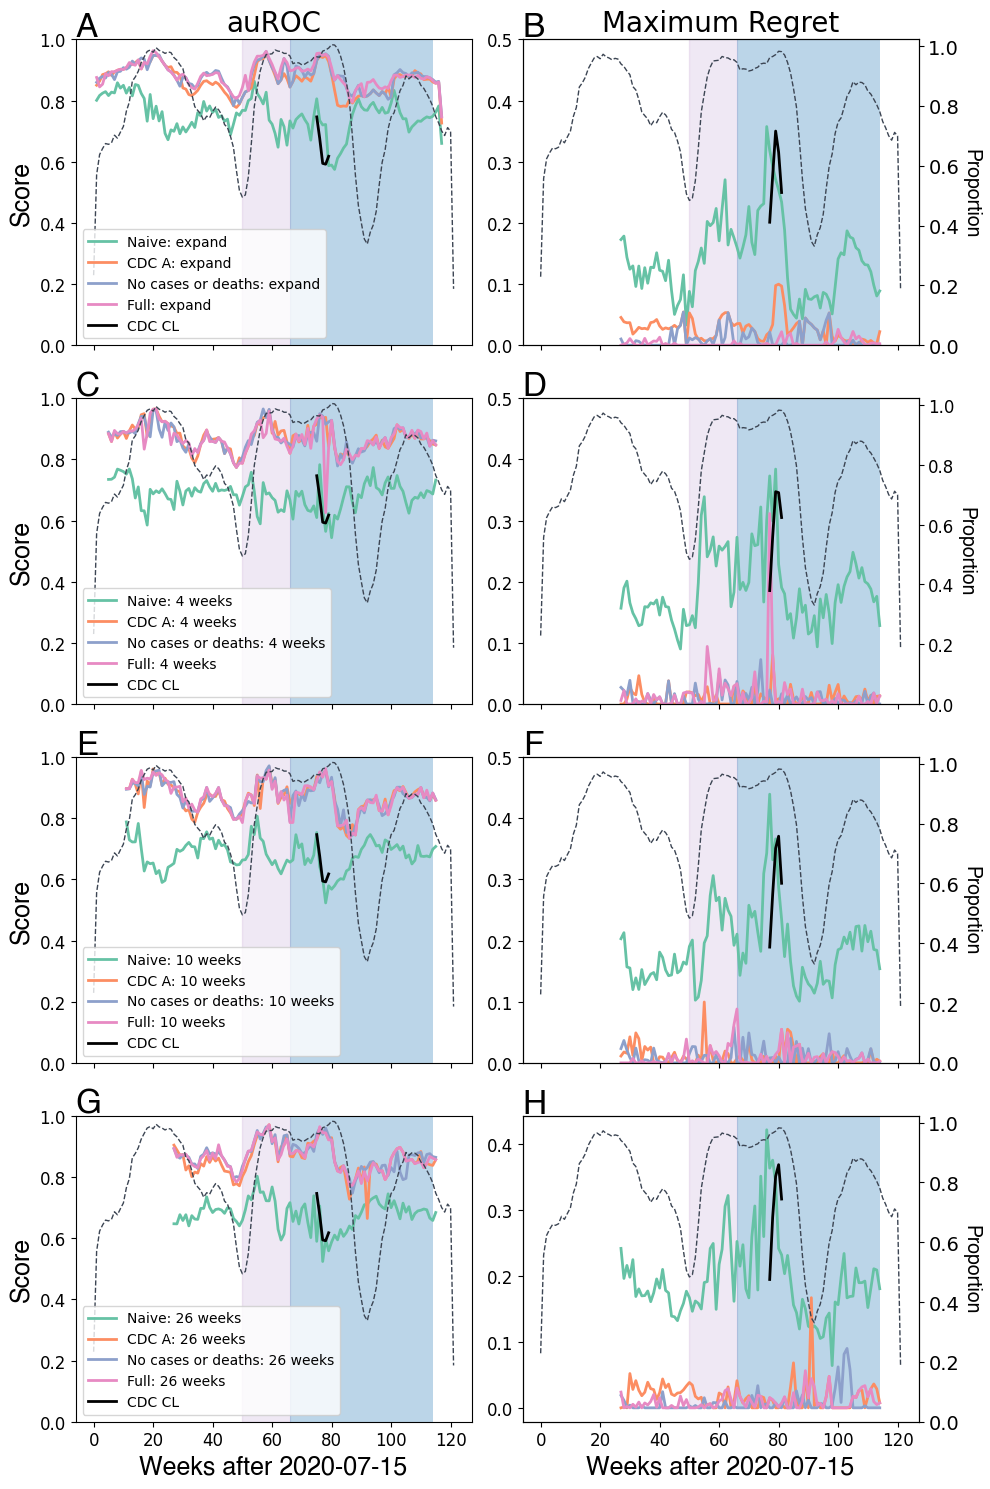

In [152]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 15), sharex = 'all')
axs = axs.ravel()

weeks_to_predict_expanding = range(1, 118)

axs[0].plot(weeks_to_predict_expanding,  ROC_by_week_naive_exact, label='Naive: expand', linewidth = 2, color = palette[0])
axs[0].plot(weeks_to_predict_expanding,  ROC_by_week_CDC_A_exact, label='CDC A: expand', linewidth = 2, color = palette[1])
#axs[0].plot(weeks_to_predict_expanding,  ROC_by_week_CDC_B_exact, label='CDC B: expand', linewidth = 2, color = palette[1])
axs[0].plot(weeks_to_predict_expanding,  ROC_by_week_full_exact_removed, label='No cases or deaths: expand', linewidth = 2, color = palette[2])
axs[0].plot(weeks_to_predict_expanding,  ROC_by_week_full_exact, label='Full: expand', linewidth = 2, color = palette[3])
axs[0].plot(range(75, 80), ROC_by_week_CL_mod[76:81], label='CDC CL', linewidth=2, color='black')


axs[2].plot(weeks_to_predict_four_week_graph,  list(model_metric_ROC_4.values())[0], label='Naive: 4 weeks', linewidth = 2, color = palette[0])
axs[2].plot(weeks_to_predict_four_week_graph,  list(model_metric_ROC_4.values())[1], label='CDC A: 4 weeks', linewidth = 2, color = palette[1])
axs[2].plot(weeks_to_predict_four_week_graph,  list(model_metric_ROC_4.values())[2], label='No cases or deaths: 4 weeks', linewidth = 2, color = palette[2])
axs[2].plot(weeks_to_predict_four_week_graph,  list(model_metric_ROC_4.values())[3], label='Full: 4 weeks', linewidth = 2, color = palette[3])
axs[2].plot(range(75, 80), ROC_by_week_CL_mod[76:81], label='CDC CL', linewidth=2, color='black')


axs[4].plot(weeks_to_predict_ten_week_graph,  list(model_metric_ROC_10.values())[0] , label='Naive: 10 weeks', linewidth = 2, color = palette[0])
axs[4].plot(weeks_to_predict_ten_week_graph,  list(model_metric_ROC_10.values())[1], label='CDC A: 10 weeks', linewidth = 2, color = palette[1])
axs[4].plot(weeks_to_predict_ten_week_graph,  list(model_metric_ROC_10.values())[2], label='No cases or deaths: 10 weeks', linewidth = 2, color = palette[2])
axs[4].plot(weeks_to_predict_ten_week_graph,  list(model_metric_ROC_10.values())[3], label='Full: 10 weeks', linewidth = 2, color = palette[3])
axs[4].plot(range(75, 80), ROC_by_week_CL_mod[76:81], label='CDC CL', linewidth=2, color='black')

axs[6].plot(weeks_to_predict_twenty_six_week_graph,  list(model_metric_ROC_26.values())[0], label='Naive: 26 weeks', linewidth = 2, color = palette[0])
axs[6].plot(weeks_to_predict_twenty_six_week_graph,  list(model_metric_ROC_26.values())[1], label='CDC A: 26 weeks', linewidth = 2, color = palette[1])
axs[6].plot(weeks_to_predict_twenty_six_week_graph,  list(model_metric_ROC_26.values())[2], label='No cases or deaths: 26 weeks', linewidth = 2, color = palette[2])
axs[6].plot(weeks_to_predict_twenty_six_week_graph,  list(model_metric_ROC_26.values())[3], label='Full: 26 weeks', linewidth = 2, color = palette[3])
axs[6].plot(range(75, 80), ROC_by_week_CL_mod[76:81], label='CDC CL', linewidth=2, color='black')


axs[0].plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
axs[2].plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
axs[4].plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
axs[6].plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')


axs[0].set_title("auROC",fontsize=20)

# Plot MR 
weeks_to_plot_MR = range(116 - len_for_MR, 115)

second_axs = axs[1].twinx()
models_3 = ['Naive: Expand', 'CDC A: Expand', 'No cases or deaths: Expand', 'Full: Expand', 'CDC CL']
for i, model in enumerate(models_3):
    colour = palette[i]
    if model == 'CDC CL':
        colour = 'black'
        axs[1].plot(range(77, 82), maximum_regret_by_model_ROC_ex[model][indices_for_CL_MR[0]:indices_for_CL_MR[-1]+1], label=model, linestyle = '-', color = colour, linewidth=2)
    else:
        axs[1].plot(weeks_to_plot_MR, maximum_regret_by_model_ROC_ex[model], label=model, linestyle = '-', color = colour, linewidth=2)
second_axs.plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
second_axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
second_axs.set_ylabel('Proportion',**hfont, rotation=-90, fontsize = 14,  labelpad=15)

second_axs.tick_params(axis='y', labelsize=14)

second_axs = axs[3].twinx()
models_2 = ['Naive: 4', 'CDC A: 4', 'No cases or deaths: 4', 'Full: 4', 'CDC CL']
for i, model in enumerate(models_2):
    colour = palette[i]
    if model == 'CDC CL':
        colour = 'black'
        axs[3].plot(range(77, 82), maximum_regret_by_model_ROC_4[model][indices_for_CL_MR[0]:indices_for_CL_MR[-1]+1], label=model, linestyle = '-', color = colour, linewidth=2)
    else:
        axs[3].plot(weeks_to_plot_MR, maximum_regret_by_model_ROC_4[model], label=model, linestyle = '-', color = colour, linewidth=2)
second_axs.plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
second_axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

second_axs.tick_params(axis='both', which='major', labelsize=12)
second_axs.set_ylabel('Proportion',**hfont, rotation=-90, fontsize = 14,  labelpad=15)
axs[1].set_ylim(0,0.5)
axs[3].set_ylim(0,0.5)



second_axs = axs[5].twinx()
models_4 = ['Naive: 10', 'CDC A: 10', 'No cases or deaths: 10', 'Full: 10', 'CDC CL']
for i, model in enumerate(models_4):
    colour = palette[i]
    if model == 'CDC CL':
        colour = 'black'
        axs[5].plot(range(77, 82), maximum_regret_by_model_ROC_10[model][indices_for_CL_MR[0]:indices_for_CL_MR[-1]+1], label=model, linestyle = '-', color = colour, linewidth=2)
    else:
        axs[5].plot(weeks_to_plot_MR, maximum_regret_by_model_ROC_10[model], label=model, linestyle = '-', color = colour, linewidth=2)
second_axs.plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
second_axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
second_axs.set_ylabel('Proportion',**hfont, rotation=-90, fontsize = 14,  labelpad=15)

second_axs.tick_params(axis='y', labelsize=14)



second_axs = axs[7].twinx()
models_6 = ['Naive: 26', 'CDC A: 26', 'No cases or deaths: 26', 'Full: 26', 'CDC CL']
for i, model in enumerate(models_6):
    colour = palette[i]
    if model == 'CDC CL':
        colour = 'black'
        axs[7].plot(range(77, 82), maximum_regret_by_model_ROC_26[model][indices_for_CL_MR[0]:indices_for_CL_MR[-1]+1], label=model, linestyle = '-', color = colour, linewidth=2)
    else:
        axs[7].plot(weeks_to_plot_MR, maximum_regret_by_model_ROC_26[model], label=model, linestyle = '-', color = colour, linewidth=2)
second_axs.plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
second_axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
second_axs.tick_params(axis='y', labelsize=14)
second_axs.set_ylabel('Proportion',**hfont, rotation=-90, fontsize = 14,  labelpad=15)
axs[1].set_title("Maximum Regret",fontsize=20)

for i in range( len(axs)):
    print(i)
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    axs[i].add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                        alpha=0.3)
    axs[i].add_patch(polygon_omricon)
axs[0].set_ylabel('Score',**hfont,  fontsize = 18)
axs[2].set_ylabel('Score',**hfont,  fontsize = 18)
axs[4].set_ylabel('Score',**hfont,  fontsize = 18)
axs[6].set_ylabel('Score',**hfont,  fontsize = 18)

second_axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
second_axs.tick_params(axis='y', labelsize=14)

axs[0].set_ylim(0,1)
axs[2].set_ylim(0,1)
axs[4].set_ylim(0,1)
axs[6].set_ylim(0,1)

axs[1].set_ylim(0,0.5)
axs[3].set_ylim(0,0.5)
axs[5].set_ylim(0,0.5)

axs[6].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
axs[7].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 1, loc='lower left', fontsize='10')
axs[2].legend(ncol = 1, loc='lower left', fontsize='10')
axs[4].legend(ncol = 1, loc='lower left', fontsize='10')
axs[6].legend(ncol = 1, loc='lower left', fontsize='10')

plt.tight_layout()

plt.savefig(f'/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Performance_MR_naive_and_full__removed_expanding_train_models_exact_{size_of_test_dataset}_week_set_training_period_by_metric.png', dpi = 300, bbox_inches='tight' )